In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import json
from environment import Environment
from logging_config import setup_logging
import logging
from utils import findUE, BPRCostFunction, findSO   
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "no-latex"])
import warnings

# Ignore this specific RuntimeWarning from PoA finder
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning, 
    message="Values in x were outside bounds during a minimize step"
)


In [45]:
import pandas as pd
import random
import numpy as np

In [46]:
params = None
with open("params.json") as f:
    params = json.load(f)
if not params:
    raise Exception("No parameters found!")
env1 = Environment(params) # area with PoA ~1.1
params['env_params']['PoA'] = 1.3
env2 = Environment(params) # area with PoA ~1.3
envs = [env1,env2]

ACCIDENT: Day 93, Env 1, R0 | Impacted: 56 | Fleet Shift: +15.4016
ACCIDENT: Day 96, Env 2, R2 | Impacted: 51 | Fleet Shift: +14.6468
ACCIDENT: Day 230, Env 2, R1 | Impacted: 55 | Fleet Shift: +8.3950


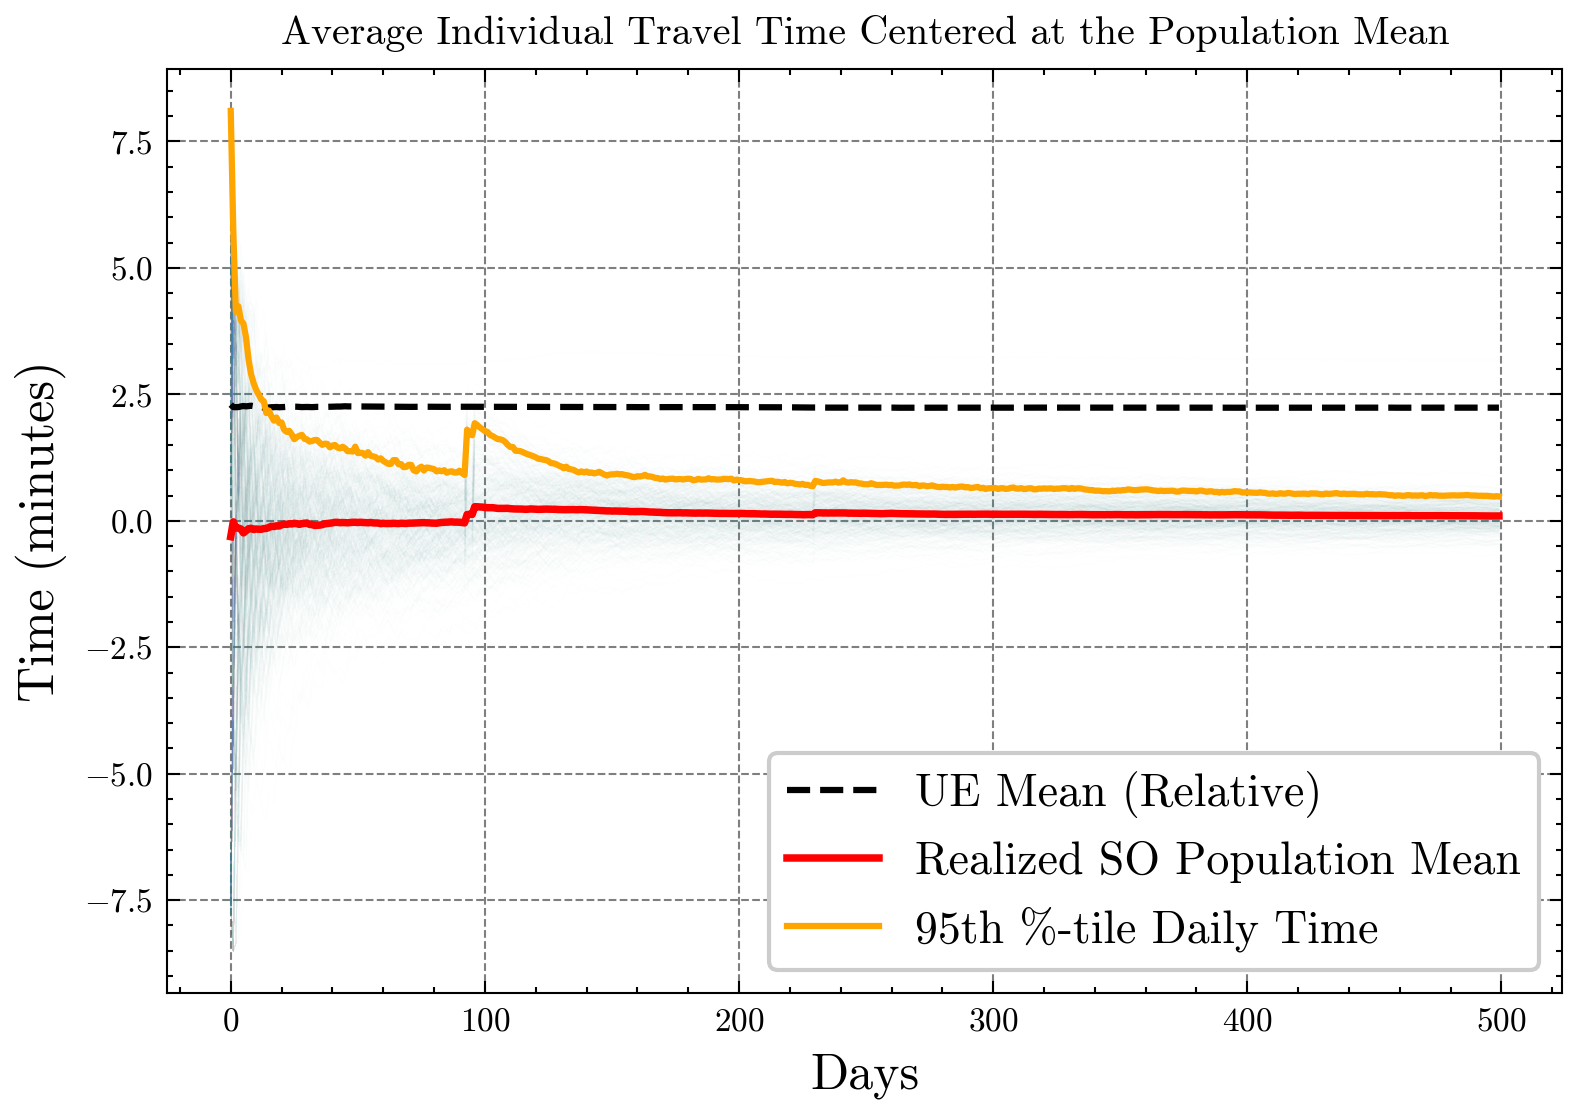

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scienceplots

plt.style.use(["science", "nature", "grid", "no-latex"])

Q = params["env_params"]["Q"]
choices = list(range(params["env_params"]["destinations"])) + [-1]
num_choices = len(choices)

df = pd.DataFrame(index=range(Q))
df["I"] = np.random.normal(0, 1e-12, size=len(df))
df["total_time_SO"] = 0.0
df["total_time_UE"] = 0.0
df["total_time_ideal_SO"] = 0.0

history_avg_I_sq = []
history_avg_SO = []
history_avg_UE = []
history_ideal_SO = []
history_p95_avg_SO = []
history_std_avg_SO = []
agent_avg_trajectories = []
history_cum_benefit_fleet = []

def day(df, d, params):
    df["choice"] = np.random.choice(choices, size=len(df))
    if d < params["env_params"]["fresh_after"]:
        df["choice"] = df.apply(
            lambda x: x["choice"] if x.name > params["env_params"]["fresh_share"] else 0,
            axis=1,
        )

    df["t_today_SO"] = 0.0
    df["t_today_UE"] = 0.0
    df["t_today_ideal_SO"] = 0.0

    for i, env in enumerate(envs):
        k = len(env.routes)
        mask = df["choice"] == i
        Q_env = mask.sum()
        if Q_env == 0: continue

        # Rank agents by historical inequity (I)
        df.loc[mask, "I_rank"] = df.loc[mask, "I"].rank(ascending=False, method='first').astype(int)
        
        q_env = params["env_params"]["congestion"] * Q_env / (Q / num_choices)
        X_ue, _ = findUE(q_env, env.routes)
        tUE_val = env.routes[0](X_ue[0])
        
        X_so, T_so = findSO(q_env, env.routes)
        hat_T = T_so / q_env # Perfect setting SO time (Ideal)
        tSO_list = np.array([env.routes[j](X_so[j]) for j in range(k)])
        
        # Realize travel times with noise/disruptions
        noise = np.random.normal(1, params["env_params"]["noise"], size=k)
        disruption_mult = np.random.choice([1, 10], p=[1 - params["env_params"]["p_disruption"], params["env_params"]["p_disruption"]], size=k)
        real_tSO = tSO_list * noise * disruption_mult

        # Assignment Logic
        route_order = tSO_list.argsort()
        exact_counts = (X_so[route_order] / X_so.sum()) * Q_env
        counts = np.diff(np.round(np.cumsum(np.insert(exact_counts, 0, 0)))).astype(int)
        splits = np.cumsum(counts)

        agent_ranks = df.loc[mask, "I_rank"].values - 1
        assigned_bins = np.clip(np.searchsorted(splits, agent_ranks, side='right'), 0, k-1)
        df.loc[mask, "route"] = route_order[assigned_bins]
        
        # Accident Logging
        for r_idx in range(k):
            if disruption_mult[r_idx] > 1:
                n_on_route = (df.loc[mask, "route"] == r_idx).sum()
                fleet_impact = ((real_tSO[r_idx] - tSO_list[r_idx]) * n_on_route) / Q
                print(f"ACCIDENT: Day {d}, Env {i+1}, R{r_idx} | Impacted: {n_on_route} | Fleet Shift: +{fleet_impact:.4f}")
        
        daily_time_map = {idx: real_tSO[idx] for idx in range(k)}
        df.loc[mask, "t_today_SO"] = df.loc[mask, "route"].map(daily_time_map)
        df.loc[mask, "t_today_UE"] = tUE_val
        df.loc[mask, "t_today_ideal_SO"] = hat_T
        df.loc[mask, "inequity_today"] = df.loc[mask, "t_today_SO"] - hat_T
        df.loc[mask, "I"] += df.loc[mask, "inequity_today"]

    df["total_time_SO"] += df["t_today_SO"]
    df["total_time_UE"] += df["t_today_UE"]
    df["total_time_ideal_SO"] += df["t_today_ideal_SO"]
    return df

# --- Simulation Loop ---
total_days = params["env_params"]["days"]
for d in range(total_days):
    df = day(df, d, params)
    day_idx = d + 1
    
    current_avg_SO = df["total_time_SO"] / day_idx
    current_avg_ideal_SO = df["total_time_ideal_SO"] / day_idx
    current_avg_UE = df["total_time_UE"] / day_idx
    
    history_avg_I_sq.append(np.mean(df["I"]**2) / day_idx)
    history_avg_SO.append(current_avg_SO.mean())
    history_avg_UE.append(current_avg_UE.mean())
    history_ideal_SO.append(current_avg_ideal_SO.mean())
    history_cum_benefit_fleet.append((df["total_time_UE"].sum() - df["total_time_SO"].sum()) / Q)
    
    history_p95_avg_SO.append(np.percentile(current_avg_SO, 95))
    history_std_avg_SO.append(current_avg_SO.std())
    agent_avg_trajectories.append(current_avg_SO.values.copy())

ideal_so_array = np.array(history_ideal_SO).reshape(-1, 1)
centered_matrix = np.array(agent_avg_trajectories) - ideal_so_array
centered_real_avg_so = np.array(history_avg_SO) - np.array(history_ideal_SO)
centered_p95_so = np.array(history_p95_avg_SO) - np.array(history_ideal_SO)
centered_ue_mean = np.array(history_avg_UE) - np.array(history_ideal_SO)


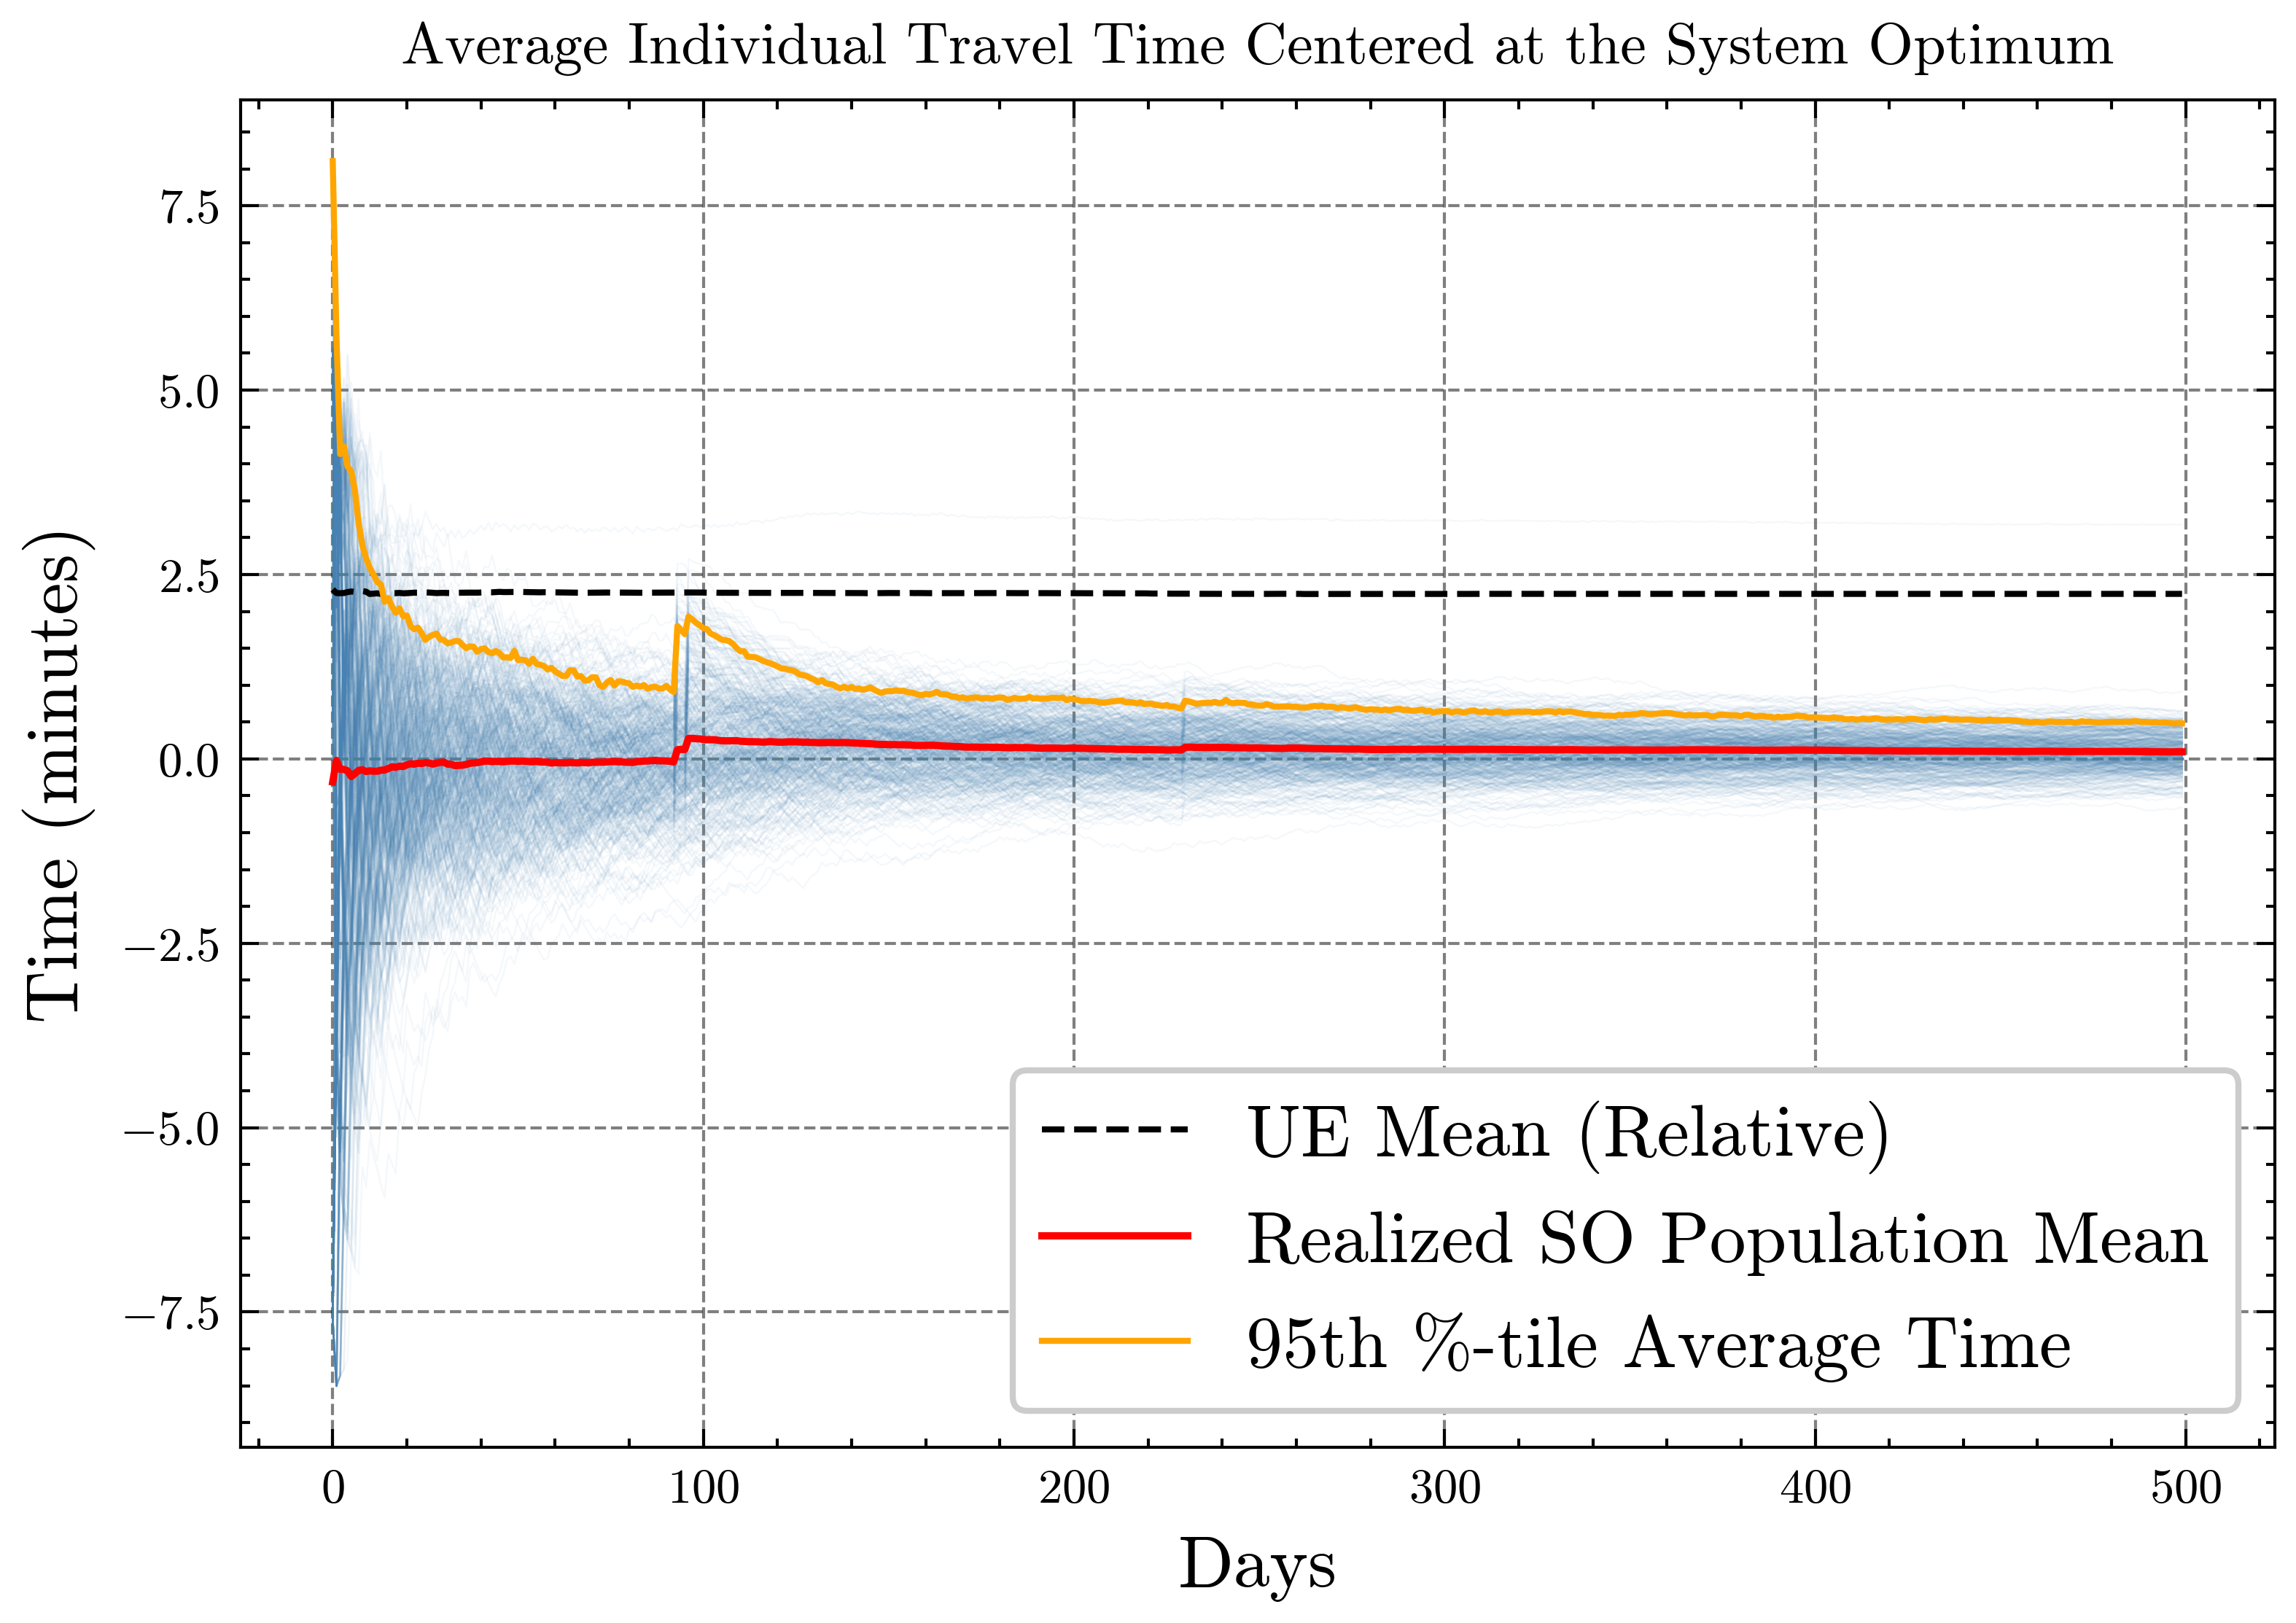

In [ ]:
plt.figure(figsize=(6,4), dpi=600)
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'axes.labelsize': 12, 'legend.fontsize': 12, 'xtick.labelsize': 8, 'ytick.labelsize': 8})

plt.plot(centered_matrix, color='steelblue', alpha=0.05, linewidth=0.3) 
plt.plot(centered_ue_mean, color='black', linewidth=1, linestyle='--', label="UE Mean (Relative)")
plt.plot(centered_real_avg_so, color='red', linewidth=1.2, label="Realized SO Population Mean")
plt.plot(centered_p95_so, color='orange', linewidth=1, label="95th %-tile Average Time")

plt.title("Average Individual Travel Time Centered at the System Optimum")
plt.ylabel("Time (minutes)")
plt.xlabel("Days")

plt.legend(loc='lower right')

plt.savefig("bits_experiment.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()